# Airbnb's Business Question and Plan for Success

## Understanding the Business Question

-- The Objective of the Business Problem:

    -- 1.0. Prediction of which country a new user's first booking destination will be upon using Airbnb.

-- Proposal for Solution:

-- 

## The Business Planning

# <font color = 'green'> ----- Cycle 1: First Sprint ----- </font>

# 0. Imports 

## 0.1. Libraries:

In [1]:
import sys

!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install scikit-plot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import random

import pandas  as pd
import numpy   as np
import seaborn as sns

from IPython.core.display import HTML
from datetime             import datetime, timedelta

from matplotlib import pyplot as plt
from scipy      import stats  as ss

from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import metrics         as m

from scikitplot import metrics as mt

from keras import models as ml
from keras import layers as l

2022-03-21 12:46:56.641817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 12:46:56.641850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 0.2. Helper Functions

In [3]:
# Função auxiliar para construcão do layout:
def jupyter_settings():
    %matplotlib inline
#     %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams[ 'figure.figsize' ] = [12, 6]
    plt.rcParams[ 'font.size' ] = 20
    
    display( HTML( '<style>.container { width:95% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

In [5]:
# Funcão de correlacão de variáveis categóricas, utilizando do método estatístico de Cramer's V:
def cramer_v( x, y ):
    
    #Inicialmente, calcula-se a "confusion matrix"
    cm = pd.crosstab( x, y ).values
    
    #Calcula-se as variáveis do método
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    #Ao final, a funcão retorna a própria equacão de cramer's V
    return np.sqrt( ( chi2/n )/( min(  k-1, r-1 ) ) )

## 0.3. Loading the data

In [6]:
# Dataset for training the users inherent characteristics:
df_users = pd.read_csv( 'datasets/training_users.csv', low_memory=True )

In [7]:
# Dataset for training the users behaviors upon using the platform:
df_sessions = pd.read_csv( 'datasets/sessions.csv', low_memory=True )
print( 'Data size for df_sessions: {}'.format(df_sessions.shape) )

# Para o caso de se realizar um merge de ambos os datasets devido a GRANULARIDADE.

# A fim de decidir qual granularidade deverá ser implementada no merge dos datasets, as seguintes questões devem ser consideradas:
## A previsão é feita em funcão do usuário
## A previsão é feita em funcão do usuário + evento ('action')

# Exemplo: Retornar as acões realizadas por um usuário aleatório da plataforma durante o período em que esteve ativo:
df_sessions[ df_sessions['user_id'] == '00023iyk9l' ][['user_id', 'action']].groupby('user_id').count()

# Da mesma forma, a fim de retornar os valores referentes à todas as acões do usuário '00023iyk9l':
df_sessions[ df_sessions['user_id'] == '00023iyk9l' ][['user_id', 'action']].value_counts()


Data size for df_sessions: (10567737, 6)


user_id     action               
00023iyk9l  show                     9
            requested                5
            dashboard                4
            index                    4
            personalize              4
            similar_listings         3
            ajax_refresh_subtotal    2
            header_userpic           2
            travel_plans_current     2
            callback                 1
            confirm_email            1
            pending                  1
            search_results           1
dtype: int64

## 0.4. Defining the granularity for both datasets

## 0.5. Merging both dataset

# 1. Data Description

In [8]:
df1 = df_users.copy()

## 1.1. Data Dimensions

In [9]:
# Data dimensions for the 'users.csv' dataset:
print( 'Data size for df_users: \n\nNumber of rows = {} \nNumber of columns = {}'.format(df_users.shape[0],df_users.shape[1]) )

Data size for df_users: 

Number of rows = 213451 
Number of columns = 16


In [10]:
# Printing the size of the sessions dataset:
print( 'Data size for df_sessions: \n\nNumber of rows = {} \nNumber of columns = {}'.format(df_sessions.shape[0],df_sessions.shape[1]) )

Data size for df_sessions: 

Number of rows = 10567737 
Number of columns = 6


## 1.2. Data Types

In [11]:
df_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [12]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [13]:
df1.sample().T

,136053
id,6lij499lpu
date_account_created,2013-12-28
timestamp_first_active,20131228202039
date_first_booking,NaN
gender,MALE
age,29.0
signup_method,facebook
signup_flow,12
language,en
affiliate_channel,api


## 1.3. Checking for presence of NA data

### 1.3.1. Checking the 'users.csv' dataset

In [14]:
df1.isna().sum() / len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [15]:
# Checking the reason to why there are 58% of missing data (NA) within the 'date_first_booking' feature:
aux = df1[ df1['date_first_booking'].isna() ]   #returns only 'date_first_booking' containing NA values.
aux['country_destination'].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

The snippet above shows that 100% of the users who did not make any bookings on their first use of the platform represent 100% of all the 'country_destination' feature which possesses 'NDF' (No destination found) value. This is due the fact that people who browsed on the platform and didn't book any place are the same people who have no country destination.

However, the time the user took from the moment they entered the website to the moment they made their first booking is an important variable.



In [16]:
# Maximum date which one can project the date (Since the raw dataset is not updated!):
pd.to_datetime(df1['date_first_booking']).max()

Timestamp('2015-06-29 00:00:00')

In [17]:
# 'date_first_booking' -> date of first booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

In [18]:
# 'age':
aux = df1[df1['age'].isna()]
aux['country_destination'].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

In this case, one is necessary to visualize how the 'age' feature is distributed (18 <= 'age' <= 65) within the variable 'country_destination', as follows...

/home/renanpacheco/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


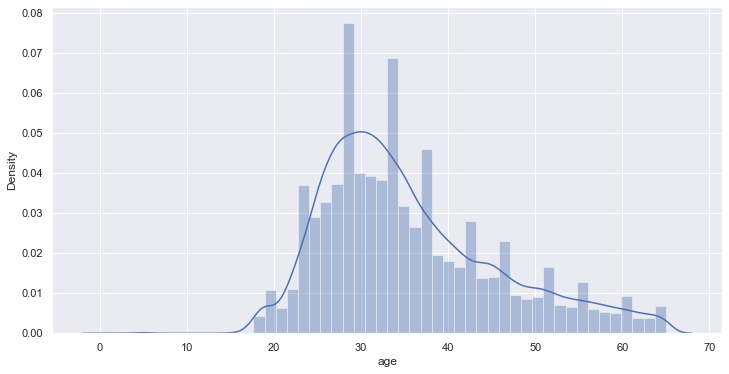

In [19]:
sns.distplot(df1[df1['age'] <= 65]['age']);

As the plot above suggests, the distribution of the ages within the dataset suggests a gaussian distribution, even though it possesses a significant tale at the end and a skewness towards the ages ranging between 20 and 30 years old.

Due to this, in case of substituting the missing data (NA) by the average of these data plus its correspondent standard deviation, there is no bias on the analysis. 



In [20]:
age_avg = int( round(df1['age'].mean()) )
age_avg


50

In [21]:
df1['age'] = df1['age'].fillna(age_avg)

In [22]:
## 'first_affiliate_tracked' ->  whats the first marketing the user interacted with before the signing up:
df1['first_affiliate_tracked'].drop_duplicates()


0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

The percentage of missing data (NA) regarding the 'first_affiliate_tracked' is about 3%, considering the totality of missing data throughout the raw dataset. 

When inputing data in categorical features, in order to replace missing data, it's common to use the frequency associated with each parameter. But this has a huge impact, once it could crease a biased analysis.

Due to this, **the 'first_affiliate_tracked' will not be considered in this cycle of the CRISP** and other features will be used throughout the Cross Validation process.

In [23]:
df1 = df1[~df1['first_affiliate_tracked'].isna()]

df1.isna().sum() / len(df1)

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

### 1.3.2. Checking the 'sessions.csv' dataset

In [24]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

 Checking the above dataset, it' possible to make a few assumptions:

- Even though the 'user_id' has only 3% of missing data, it is key for connecting both datasets 'users.csv' and 'sessions.csv' and thus, it cannot be replaced by any other data. It has to be dropped out.

- Both features 'action_type' and 'action_detail' has the same amount of missing data, which could be presumed that both are intrinsically correlated. It thus needs to be further analysed.

In [25]:
# user_id (0.3%)
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action (0.7%)
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type (11%)
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail (11%)
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

df_sessions.isna().sum() / len(df_sessions)

user_id          0.000000
action           0.000000
action_type      0.000000
action_detail    0.000000
device_type      0.000000
secs_elapsed     0.012526
dtype: float64

For the 'time_elapsed' feature, an analysis could be done...

/home/renanpacheco/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='secs_elapsed', ylabel='Density'>

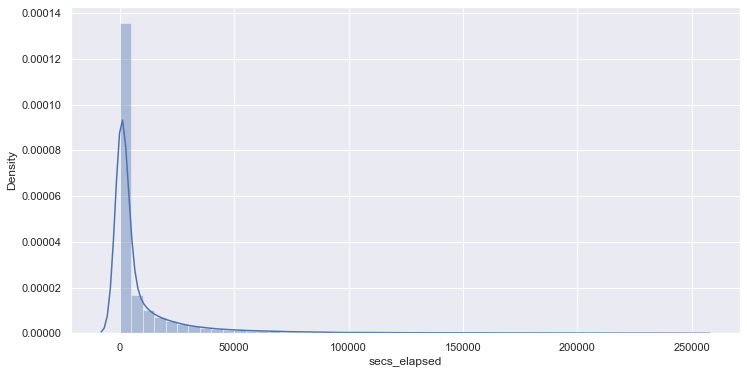

In [26]:
# sns.distplot( df_sessions['secs_elapsed'].sample(100000) );

aux = df_sessions[df_sessions['secs_elapsed'] < 0.25e6]

sns.distplot( aux['secs_elapsed'].sample(100000) )

In [27]:
aux['secs_elapsed'].mean()

11483.754623783343

In [28]:
# secs_elapsed (1.2%)
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

df_sessions.isna().sum() / len(df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.4. Changing the Data Types

In [29]:
## Num primeiro momento (1º ciclo CRISP), valores NA não serão considerados durante a análise do modelo. Isso porque o objetivo é atingir velocidade 
## na apresentação dos resultados iniciais. Caso as variáveis 'date_first_booking', 'age' e 'first_affliate_tracked', em um 2º ciclo do projeto, sejam interessante 
## para a modelagem, então estes serão introduzidos como features relevantes para a análise.

# Shape of dataframe containing NA data:
print( 'Number of total columns before NA dropping for df1: {}'.format( df_users.shape[1] ) )
print( 'Number of total rows before NA dropping for df1: {}'.format( df_users.shape[0] ) )

# # Removing missing values (Containing NA):
# df1 = df1.dropna()

# Shape of dataframe after removing NA data:
print( '\nNumber of total columns after NA dropping for df1: {}'.format( df1.shape[1] ) )
print( 'Number of total rows after NA dropping for df1: {}'.format( df1.shape[0] ) )

Number of total columns before NA dropping for df1: 16
Number of total rows before NA dropping for df1: 213451

Number of total columns after NA dropping for df1: 16
Number of total rows after NA dropping for df1: 207386


In [30]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [31]:
# Date which the account was created ('date_account_created'):
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# Timestamp that the user was active the first time ('timestamp_first_active'):
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format = '%Y%m%d%H%M%S' )

## (In this case, it'll be necessary to not only change from 'int64' to 'datetime', but also to divide into an actual date pattern)

# Date for when the user booked the first time ('date_first_booking'):
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# Age:
df1['age'] = df1['age'].astype( int )


In [32]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.5. Checking of Balanced Data

In [33]:
df1['country_destination'].value_counts( normalize=True )

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.6. Analysis of Descriptive Statistics

### 1.6.1. Numerical variables


#### 1.6.1.1. Numerical variables - users.csv

In [34]:
num_attributes  = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes  = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

In [35]:
# Central Tendency metrics:

## mean
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T

## median
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# ---------------------------------------------------
# Dispersion metrics:

## standard deviation
dis1 = pd.DataFrame(num_attributes.apply(np.std)).T

## minimum:
dis2 = pd.DataFrame( num_attributes.apply(min) ).T

## maximum:
dis3 = pd.DataFrame( num_attributes.apply(max) ).T

## range:
dis4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min()) ).T

## skewness:
dis5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T

## kurtosis:
dis6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


# Concatenating all values:
ct = pd.concat( [dis2, dis3, dis4, ct1, ct2, dis1, dis5, dis6] ).T.reset_index()

ct.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'STD', 'Skew', 'Kurtosis']
ct.head()

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,age,1.0,2014.0,2013.0,49.587976,49.0,118.422080,16.323402,267.428573
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


#### 1.6.1.2. Numerical variables - sessions.csv

In [36]:
num_attributes_sessions  = df_sessions.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions  = df_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'] )

In [37]:
# Central Tendency metrics:

## mean
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T

## median
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# ---------------------------------------------------
# Dispersion metrics:

## standard deviation
dis1 = pd.DataFrame( num_attributes_sessions.apply(np.std) ).T

## minimum:
dis2 = pd.DataFrame( num_attributes_sessions.apply(min) ).T

## maximum:
dis3 = pd.DataFrame( num_attributes_sessions.apply(max) ).T

## range:
dis4 = pd.DataFrame( num_attributes_sessions.apply(lambda x: x.max() - x.min()) ).T

## skewness:
dis5 = pd.DataFrame( num_attributes_sessions.apply(lambda x: x.skew())).T

## kurtosis:
dis6 = pd.DataFrame( num_attributes_sessions.apply(lambda x: x.kurtosis()) ).T


# Concatenating all values:
ct = pd.concat( [dis2, dis3, dis4, ct1, ct2, dis1, dis5, dis6] ).T.reset_index()

ct.columns = ['Atributes', 'Max', 'Min', 'Range', 'Mean', 'Median', 'STD', 'Skew', 'Kurtosis']
ct.head()

,Atributes,Max,Min,Range,Mean,Median,STD,Skew,Kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.2. Categorical variables

#### 1.6.2.1. Categorical variables - users.csv

In [38]:
df1.select_dtypes( include=['object'] ).dtypes

id                         object
gender                     object
signup_method              object
language                   object
affiliate_channel          object
affiliate_provider         object
first_affiliate_tracked    object
signup_app                 object
first_device_type          object
first_browser              object
country_destination        object
dtype: object

In [39]:
cat_attributes.drop( 'id',  axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


#### 1.6.2.2. Categorical variables - sessions.csv

In [40]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [41]:
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


As one might see above, there is a huge list of levels of categorical variables to be encoded, thus impossible to continue with such analysis.

What could be done, however, is to check if either these unique categorical variables have any correlation amongst themselves or not...

For checking the correlation amongst categorical variables, the <font color='yellow'>metric of analysis for statistical correlation amongst categorical variables</font> is the Cramer-V:

In [42]:
# List of attributes for Cramer's V correlation:
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range( len(cat_attributes_list) ):
    
    corr_list = []
    for j in range( len(cat_attributes_list) ):

        ref  = cat_attributes_list[i]   #i = regarding the row
        feat = cat_attributes_list[j]   #j = regarding the column
        
        # Making the proper correlation:
        corr = cramer_v( cat_attributes_sessions[ref], cat_attributes_sessions[feat] )
        
        # Appending a list:
        corr_list.append( corr )
        
    corr_dict[ref] = corr_list

In [43]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns) # setting of index for writing the columns names
d

,action,action_type,action_detail,device_type
action,1.000000,0.952732,0.795149,0.259848
action_type,0.952732,1.000000,0.980624,0.082041
action_detail,0.795149,0.980624,1.000000,0.219622
device_type,0.259848,0.082041,0.219622,1.000000


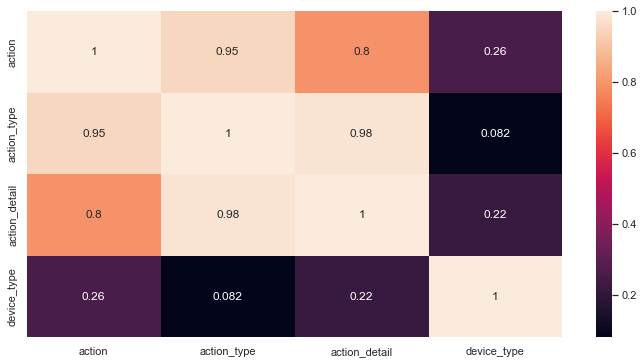

In [44]:
sns.heatmap(d, annot=True);

By analysing the table above, one may draw the following conclusions:

- Both **'action'** and **'action_type'** are 95% mutually correlated. However, upon analysing the categorical attributes table, it's clear that the **'action'** attribute has 347 unique values. Hence, since just the **'action_type'** can be used, **'action'** can be dropped from the set. <u>**Following the Occam's Razor proposition, for a model to not overfit itself, it must have the smallest dimension possible.**</u>
- Same as with the **'action'** attribute, **'action_detail'** has 98% of mutual correlation. Having 155 unique values makes it difficult to be encoded and, thus, will also be disregarded from the set.
- 

<font color='green'>In a nutshell: **'action'** and **'action_detail'** will be dropped out.</font>

# 2. Feature Engineering

How to find outliers in a multigroup dataset:

https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/abs/10.1002/cem.3233

https://link.springer.com/article/10.3758/s13428-015-0687-8#:~:text=Such%20variables%20will%20be%20referred,is%20common%20across%20the%20groups.

https://www.sciencedirect.com/science/article/abs/pii/S0169743921000782



In [45]:
df2 = df1.copy()

In [46]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1. Creating new features

In [47]:
df2['gender'].sample(15)

61838     -unknown-
149981       FEMALE
120075    -unknown-
23194        FEMALE
157482    -unknown-
141879    -unknown-
181747    -unknown-
103737       FEMALE
187370       FEMALE
15003        FEMALE
162732       FEMALE
48571     -unknown-
125267         MALE
92402          MALE
28612     -unknown-
Name: gender, dtype: object

### 2.1.1. Features time-related

In [48]:
# (Converting first_active from timestamp to datetime):
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime('%Y-%m-%d') )

# Features for describing important periods:

## Feature for period between 'timestamp_first_active' and 'date_account_created':
df2['first_active~account_creation'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)
 
## Feature for period between 'date_account_created' and 'date_first_booking':
df2['account_created~first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

## Feature for period between 'timestamp_first_active' and 'date_first_booking':
df2['first_active~first_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)


# Features derived from other date features:

# ================================ First active ================================

## year - first active:
df2['year_first_active'] = df2['first_active'].dt.year

## month - first active:
df2['month_first_active'] = df2['first_active'].dt.month

## week of year - first active:
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

## day of week - first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

## day - first active:
df2['day_first_active'] = df2['first_active'].dt.day


# ================================ First booking ================================


df2['year_first_booking'] = df2['date_first_booking'].dt.year

## month - first booking:
df2['month_first_booking'] = df2['date_first_booking'].dt.month

## week of year - first booking:
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

## day of week - first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

## day - first booking:
df2['day_first_booking'] = df2['date_first_booking'].dt.day



# ================================ Account created ================================


df2['year_account_created'] = df2['date_account_created'].dt.year

## month - first booking:
df2['month_account_created'] = df2['date_account_created'].dt.month

## week of year - first booking:
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

## day of week - first booking
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

## day - first booking:
df2['day_account_created'] = df2['date_account_created'].dt.day

/tmp/ipykernel_18536/2717654183.py:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
/tmp/ipykernel_18536/2717654183.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
/tmp/ipykernel_18536/2717654183.py:64: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [49]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,first_active,first_active~account_creation,account_created~first_booking,first_active~first_booking,year_first_active,month_first_active,week_of_year_first_active,day_of_week_first_active,day_first_active,year_first_booking,month_first_booking,week_of_year_first_booking,day_of_week_first_booking,day_first_booking,year_account_created,month_account_created,week_of_year_account_created,day_of_week_account_created,day_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2015-06-29,-unknown-,50,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2009-03-19,466,1827,2293,2009,3,12,3,19,2015,6,27,0,29,2010,6,26,0,28
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2009-05-23,732,1496,2228,2009,5,21,5,23,2015,6,27,0,29,2011,5,21,2,25
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2009-06-09,476,-57,419,2009,6,24,1,9,2010,8,31,0,2,2010,9,39,1,28
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2009-10-31,765,278,1043,2009,10,44,5,31,2012,9,36,5,8,2011,12,49,0,5
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2009-12-08,280,-208,72,2009,12,50,1,8,2010,2,7,3,18,2010,9,37,1,14


In [ ]:
df2.shape

### 2.1.2. Features related to .....

## 2.2. 

# 3. Data Filtering and Cleansing

In [ ]:
df3 = df2.copy()

In [ ]:
df3.head()

## 3.1 Filtering Rows

### 3.1.1. Analysing the 'age' feature

It is necessary to filter the ages, since there appears to exist "outlying variables" in the original dataset, i.e. ages way beyond what is considered to be normal:

In [ ]:
df3['age'].max()

In [ ]:
sns.distplot(df3['age'])

In [ ]:
plt.subplot(1, 2, 1)
sns.distplot( df3[df3['age'] < 25]['age'], kde=True );

plt.subplot(1, 2, 2)
sns.distplot( df3[(df3['age'] > 60) & (df3['age'] < 90)]['age'], kde=True );

In [ ]:
aux = df1[df1['age'] > 80][['age', 'country_destination']].sort_values('age', ascending=True)

aux.groupby('country_destination').size().sort_values() / len(aux)

# aux.groupby('country_destination').sum()

### 3.1.2. Final filtering of rows

In [ ]:
# Filtering of rows

## age: (15 < age < 120)
## (Very few people are over 120 years old and thus can be disconsidered)
df3 = df3[ (df3['age'] > 15) & (df3['age'] < 120)  ]

## 'secs_elapsed':
## (The variable must be != '0', since a null value is not possible for the website)
# df_sessions = df_sessions[df_sessions['secs_elapsed'] > 0]

## 3.2 Columns Selection

# 4. Data Preparation

In [ ]:
df3.shape

In [ ]:
df4 = df3.copy()

df4.shape

In [ ]:
# dummy variable:
df4_dummy = pd.get_dummies( df4.drop( ['id', 'country_destination'], axis=1 ) )

# Joining again 'id' and 'country_destination' with dummy variable:
df4 = pd.concat( [ df4[['id', 'country_destination']], df4_dummy ], axis=1 )

df4.shape

# 5. Feature Selection of Variables

In [ ]:
df5 = df4.copy()

df5.shape

In [ ]:
# Dropping original dates due to lack of further information that could be used by the model:
cols_drop = [ 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active' ]

df5 = df4.drop( cols_drop, axis = 1 )

In [ ]:
df5.head()

In [ ]:
df5.dtypes

# 6.0 Machine Learning Model

In [ ]:
df6 = df5.copy()

In [ ]:
print('Shape for df_users: {}'.format(df_users.shape))
print('Shape for df1: {}'.format(df1.shape))
print('Shape for df2: {}'.format(df2.shape))
print('Shape for df3: {}'.format(df3.shape))
print('Shape for df4: {}'.format(df4.shape))
print('Shape for df5: {}'.format(df5.shape))


In [ ]:
X = df5.drop( 'country_destination', axis=1 )
print(X.shape)

y = df5['country_destination'].copy()
print(y.shape)

In [ ]:
# Split of prepared dataset into training and test datasets:
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

In [ ]:
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

print( 'Shape for training set: {}'.format( x_train.shape ) )
print( 'Shape for test set: {}'.format( x_test.shape ) )

In [ ]:
x_train.head()

## 6.1. Baseline Model

### 6.1.1. Building the baseline

In [ ]:
df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

In [ ]:
# For a regression analysis, the baseline model is the average of the data. For this particular case in which
# the problem is based on a classification analysis, the baseline model must be one that *randomly chooses the
# baseline prediction*:

# (https://docs.python.org/3/library/random.html)

country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()

k_num = y_test.shape[0]

country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list,
                             weights=country_destination_weights, 
                             k=k_num)


### 6.1.2. Evaluation of baseline model performance

In [ ]:
# Accuracy
accur_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy from model: {}%'.format( accur_random*100 ) )

In [ ]:
# Confusion matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12, 12) );

In [ ]:
# Balanced Accuracy
balanced_accur_random = m.balanced_accuracy_score(y_test, yhat_random)
print( '\nBalanced accuracy for NN: {}%\n'.format(balanced_accur_random*100) )

In [ ]:
# Classification Report:
print( m.classification_report(y_test, yhat_random) )

In [ ]:
# Kappa Metrics:
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print( '\nKappa Score for NN: {}%'.format(kappa_random*100) )

## 6.2. Transformation of categorical variables

In [ ]:
ohe = pp.OneHotEncoder()

# While transforming the categorical attributes (i.e. y_train) by using the One Hot Encoding transformation method, one needs
# to perform it within the Neural Network (NN):
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [ ]:
y_train_nn

### 6.1.2. Data dimensions for the constructed datasets (Report)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print('\n')
print(y_train_nn.shape)

# Analysing the datasets to be used in the NN:
print('\n')
print('x_train:')
print(x_train.shape)
print('\ny_train for NN:')
print(y_train_nn.shape)

## 6.3. Building up the Neural Network - NN MLP

In [ ]:
x_train.shape

In [ ]:
# Model definition:
model = ml.Sequential()

# First layer of neural network:
model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) ) #The binary number of neurons must always exceed
                                                                           #the amount of categorical attributes within 'x_train'.

# Second or exit layer for neural network:
model.add( l.Dense( 12, activation='softmax' ) )

# Compiling the model:
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# Training the model:
model.fit( x_train, y_train_nn, epochs=100 )

  


# 7. Neural Network (NN) Performance

## 7.1. Evaluating the prediction performance

In [ ]:
# Evaluating the prediction after testing:
pred_nn = model.predict( x_test )

# Evaluating the inverted prediction:
yhat_nn = ohe.inverse_transform( pred_nn )

# Prediction prepare:
y_test_nn = y_test.to_numpy()

yhat_nn = yhat_nn.reshape( 1, -1 )[0]

## 7.2. Post-Evaluation of Metrics

In [ ]:
# Accuracy
accur_nn = m.accuracy_score( y_test_nn, yhat_nn )

print( 'Accuracy from model: {}%'.format( accur_nn*100 ) )

In [ ]:
# Confusion matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12, 12) );

In [ ]:
# Balanced Accuracy
balanced_accur_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)

print( 'Balanced accuracy for NN: {}%'.format(balanced_accur_nn*100) )

In [ ]:
# Classification Report:
print( m.classification_report(y_test_nn, yhat_nn) )

In [ ]:
# Kappa Metrics:
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)

print( 'Kappa Score for NN: {}%'.format(kappa_nn*100) )

## 7.3. Implementing Cross Validation for NN Performance

In [ ]:
# Generating k-fold:
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_accur_list = []
kappa_accur_list = []

i = 1

for train_ix, val_ix in kfold.split( x_train, y_train ):    #Neste caso, a cada nova iteracao, a proporcao entre os dados de treino 
                                                            #e os dados de teste é mantida.
  
  # Print out of current fold in iteration:
  print( 'Fold Number: {}/{}'.format(i, num_folds) )
  
  # Getting the folds for...

  ## the training dataset:
  x_train_fold = x_train.iloc[train_ix]
  y_train_fold = y_train.iloc[train_ix]

  ## the validation ('testing') dataset:
  x_val_fold = x_train.iloc[val_ix]
  y_val_fold = y_train.iloc[val_ix]


  # Target one-hot-encoding for transforming the categorical variables from both the training and 
  # the validation dataset:
  ohe =  pp.OneHotEncoder()
  y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape(-1, 1) ).toarray()


  # Model definition:
  ## (https://keras.io/api/layers/core_layers/dense/)
  model = ml.Sequential()
  model.add( l.Dense(256, input_dim=x_train.shape[1], activation='relu') )
  model.add( l.Dense(11, activation='softmax') )

  # Compiling the model:
  model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

  # Training the model:
  model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

  # Predictions:
  pred_nn = model.predict(x_val_fold)

  ## The 'pred_nn' variable is inherently encoded by the 'x_val_fold' variable, which came from 'x_train'. Due to this, 
  ## the 'pred_nn' must be "de-encoded":
  yhat_nn = ohe.inverse_transform(pred_nn)


  # Preparing the data after the prediction built-up:
  y_test_nn = y_val_fold.to_numpy()   #The idea of converting a list of classes (in this case, 'y_val_fold') into 
                                      #an array to_numpy() is due to how the keras, from tensorflow, operates; from a list of 
                                      #classes into an array of encoded dummies.
  yhat_nn = yhat_nn.reshape(1, -1)[0]


  # Metrics:

  ## Balanced Accuracy Metrics:
  balanced_accur_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
  balanced_accur_list.append(balanced_accur_nn) 

  ## Kappa Metrics:
  kappa_accur_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
  kappa_accur_list.append(kappa_accur_nn) 

  i += 1

In [ ]:
# List for balanced accuracy, in which each position refers to the specific value of accuracy at 
# the current iterated fold.

# print(type(balanced_accur_list))

# Statistical Description for the balanced accuracy metric (Mean value + standard deviation):

print( 'Average value for Balanced Accuracy: {} +/- {:,.10f}'.format(np.mean(balanced_accur_list), np.std(balanced_accur_list)) )
print( 'Average value for Kapppa Accuracy: {} +/- {:,.10f}'.format(np.mean(kappa_accur_list), np.std(kappa_accur_list)) )

